## Model Training - House Price Prediction
This notebook handles training a regression model to predict house prices using the cleaned dataset


In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor



In [117]:

df = pd.read_csv("../data/housing_price_dataset_clean.csv")

df['house_age'] = 2025 - df['YearBuilt']

df.head()


,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price,house_age
0,2126,4,1,Rural,1969,215355.283618,56
1,2459,3,2,Rural,1980,195014.221626,45
2,1860,2,1,Suburb,1970,306891.012076,55
3,2294,2,1,Urban,1996,206786.787153,29
4,2130,5,2,Suburb,2001,272436.239065,24


In [118]:

X = df.drop("Price", axis=1)

y = df["Price"]


In [119]:
categorical_features = ["Neighborhood"]

column_transformer = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), categorical_features)
    ],
    remainder="passthrough"
)

X_encoded = column_transformer.fit_transform(X)

ohe_cols = column_transformer.named_transformers_["ohe"].get_feature_names_out(categorical_features)
num_cols = [c for c in X.columns if c not in categorical_features]
X_encoded = pd.DataFrame(X_encoded, columns=list(ohe_cols) + num_cols)
X_encoded.head()


,Neighborhood_Suburb,Neighborhood_Urban,SquareFeet,Bedrooms,Bathrooms,YearBuilt,house_age
0,0.0,0.0,2126.0,4.0,1.0,1969.0,56.0
1,0.0,0.0,2459.0,3.0,2.0,1980.0,45.0
2,1.0,0.0,1860.0,2.0,1.0,1970.0,55.0
3,0.0,1.0,2294.0,2.0,1.0,1996.0,29.0
4,1.0,0.0,2130.0,5.0,2.0,2001.0,24.0


In [120]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,       # 20% اختبار
    random_state=42      # للتكرار
)

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes: (39582, 7) (9896, 7) (39582,) (9896,)


In [121]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["auto", "sqrt"]
}


In [122]:
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,  
    n_iter=70,            
    cv=3,                            
    scoring='r2',                   
    n_jobs=-1,                   
    verbose=2,
    random_state=42
)


In [123]:
random_search.fit(X_train, y_train)
print("best", random_search.best_params_)
print("best R² (CV):", random_search.best_score_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Mariam Mohamed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 32 is smaller than n_iter=70. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Mariam Mohamed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mariam Mohamed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    

best {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
best R² (CV): 0.5529363846034646


In [128]:
best_params = {
    'n_estimators': 200,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 10
}



In [129]:
from sklearn.ensemble import RandomForestRegressor

best_rf = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)
print("Best RF model retrained ")




Best RF model retrained 


In [130]:

y_pred_best = best_rf.predict(X_test)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print("Final Test Performance:")
print(f"MAE: {mae_best:.2f}")
print(f"MSE: {mse_best:.2f}")
print(f"RMSE: {rmse_best:.2f}")
print(f"R²: {r2_best:.2f}")


Final Test Performance:
MAE: 39747.74
MSE: 2448864158.21
RMSE: 49486.00
R²: 0.56


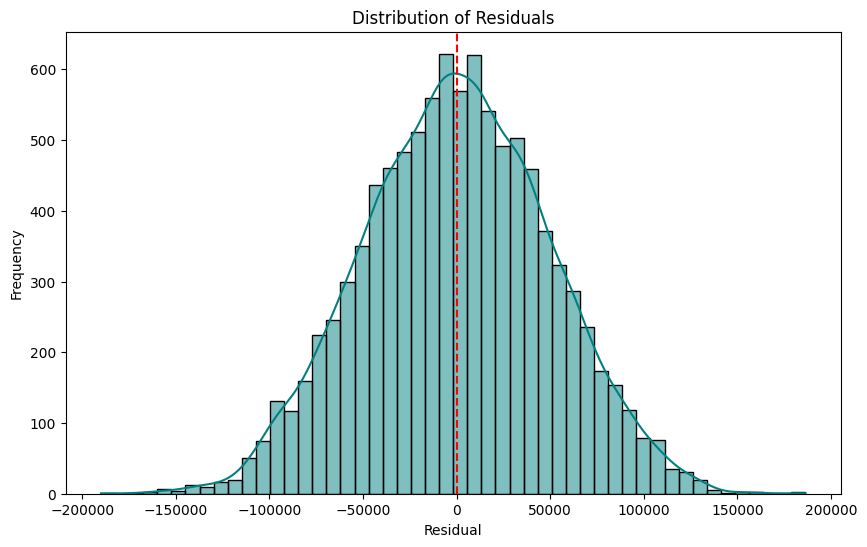

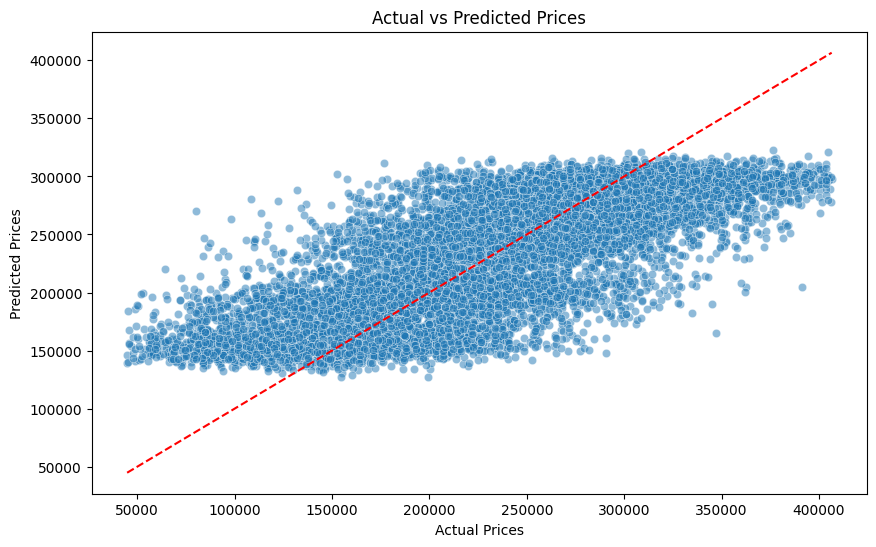

In [135]:
import seaborn as sns

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

residuals = y_test - y_pred

plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=50, kde=True, color='teal')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.savefig("../residuals_plot.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.savefig("../actual_vs_predicted.png", dpi=300, bbox_inches='tight')
plt.show()

In [133]:
import joblib

joblib.dump(best_model, "../final_model.pkl")


['../final_model.pkl']